In [25]:
using PyCall, PyPlot
@pyimport seaborn as sns

using Distributions: Chisq, Exponential, Normal, sample
import GynC: WeightedChain

In [26]:
function skimodel()
  # phyiscal model
  jumptime(x) = 1 + 1 / (0.01 * x + 0.1)

  pi0(x) = 1/100 # guessed prior
  likelihood(x,z) = pdf(Normal(jumptime(x), 0.7), z)

  
  xgrid = collect(0:0.1:100)
  zgrid = collect(0:0.1:10)

  pi0_gridded(z) = GynC.GynCChain(xgrid, map(pi0, xgrid), [likelihood(x,z) for x in xgrid, z in z])

  function samplereality(n)
    # the real prior samples
    x_t = rand(Chisq(8), n) * 5
    # and the realizations
    z_t = map(x->rand(Normal(jumptime(x), 0.7)), x)
    x_t, z_t
  end;
    
  WeightedChain(xgrid, likelihoods, map(pi0, xgrid))
end

  evidence_sampled(z, xs, w) = sum([likelihood(xs[i],z) * w[i] for i in 1:length(xs)])

evidence_sampled (generic function with 1 method)

In [27]:
function store_iterates(f::Function, start, range)
  iterates = Dict()
  curr = deepcopy(start)
  for i in 0:maximum(range)
    in(i, range) && (iterates[i] = deepcopy(curr))
    curr = f(curr)                                                                             
  end
  iterates                                                                             
end

plot_prior(wc::WeightedChain) = plot(wc.chain|>vec, wc.weights) # plot current weighting
plot_xtrue(xtrue) = plot(xtrue, fill(0, length(xtrue)), "^") # plot the leading to measurements
plot_realprior() = plot(xgrid, map(x->pdf(Chisq(8),x/5)/5, xgrid)) # plot real distribution

plot_posterior(wc::WeightedChain) = 
    plot(zgrid, map(z->evidence_sampled(z, wc.chain, wc.weights), zgrid)) # plot posterior of current weighting

plot_evidence(xtrue) =
    plot(zgrid, map(z->evidence_sampled(z, xtrue, fill(1/length(xtrue), length(xtrue))), zgrid)) # plot posterior for measured x

plot_ztrue(ztrue) = 
    plot(ztrue, fill(0, length(ztrue)), "^") # plot measured z

function plothistory(pi_n, xtrue, ztrue)
    for (n,pi) in sort(collect(pi_n), by=x->x[1])
        figure()

        subplot(121)
        hold(:on)
        
        plot_prior(pi)
        plot_realprior()        
        plot_xtrue(xtrue)
        
        title("rho^x_$n")  

        subplot(122)
        
        plot_posterior(pi)
        plot_evidence(xtrue) # note that this is just the joint pdf conditioned on xtrue, not the real posterior
        plot_ztrue(ztrue)
        
        title("rho^z_$n") 
        hold(:off)
        
        display()
        close("all")
    end
end

plothistory (generic function with 1 method)

In [28]:
range = [0;2.^(0:15)]
srand(5)

xtrue, ztrue = samplereality(20);

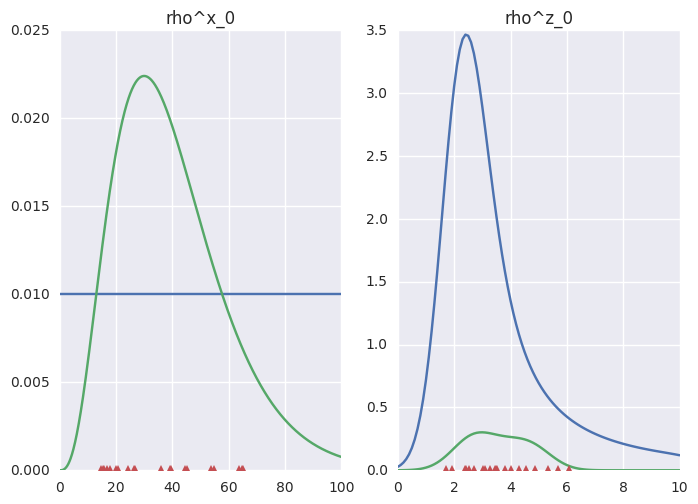

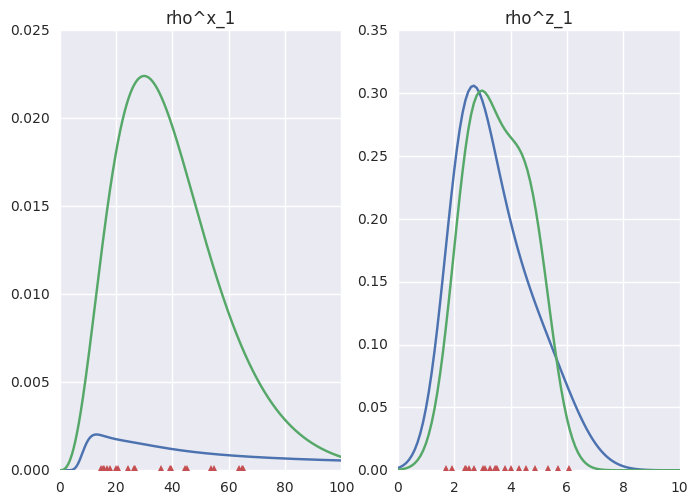

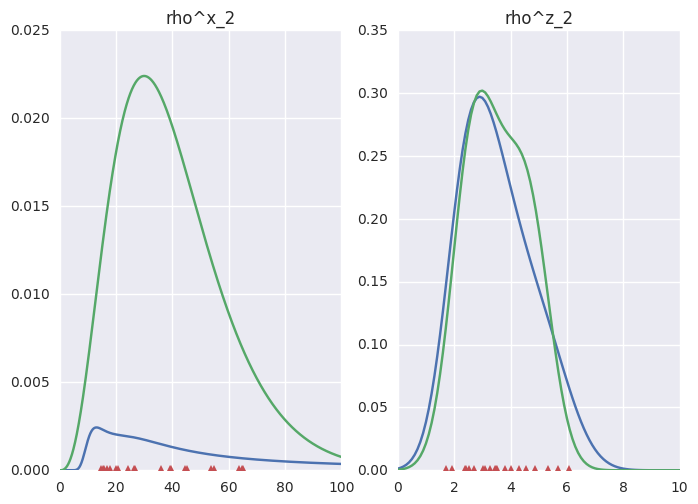

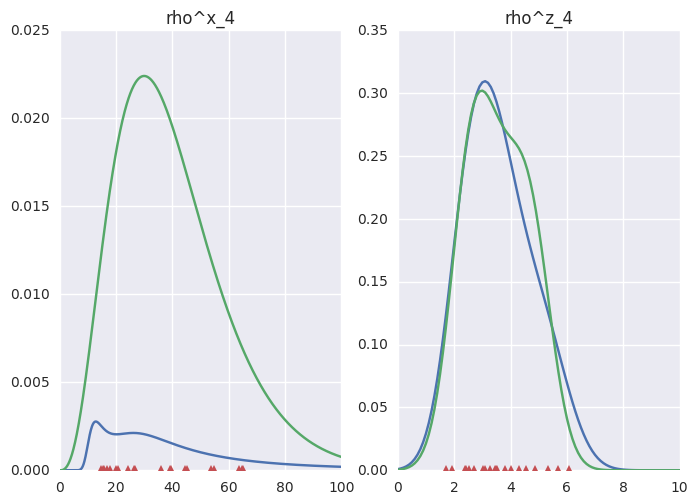

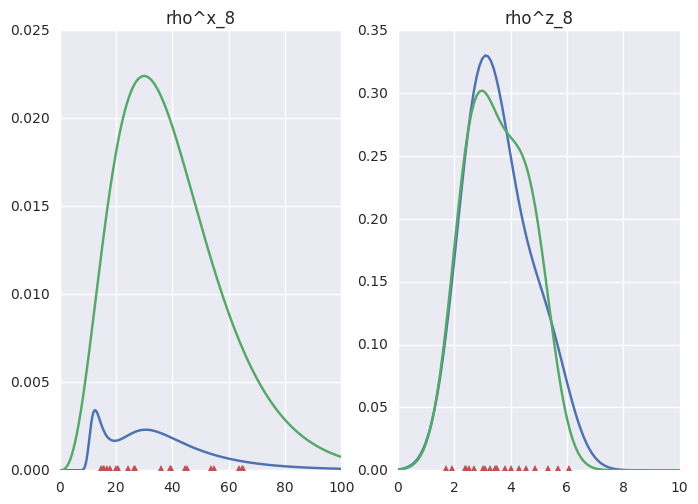

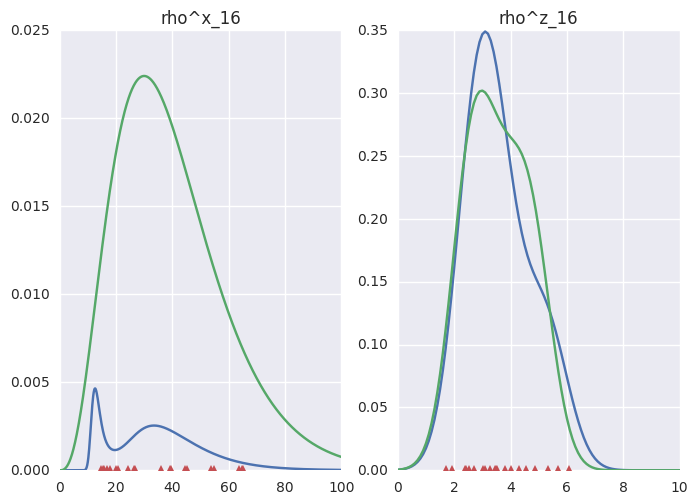

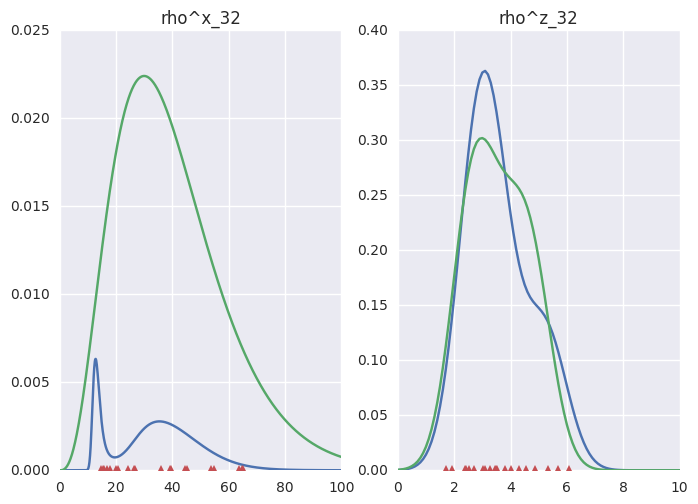

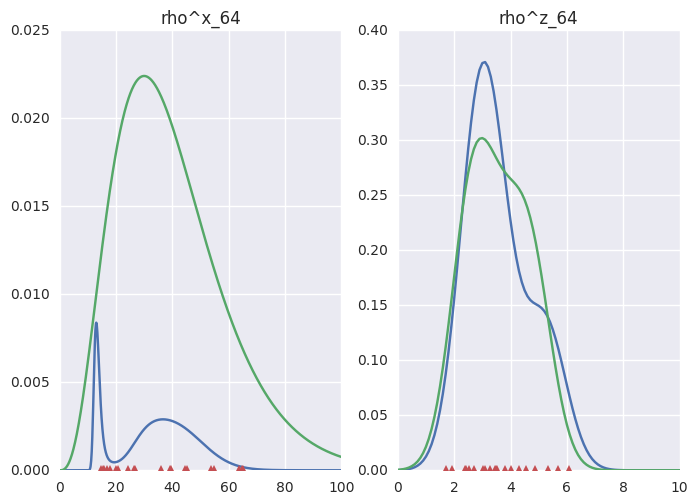

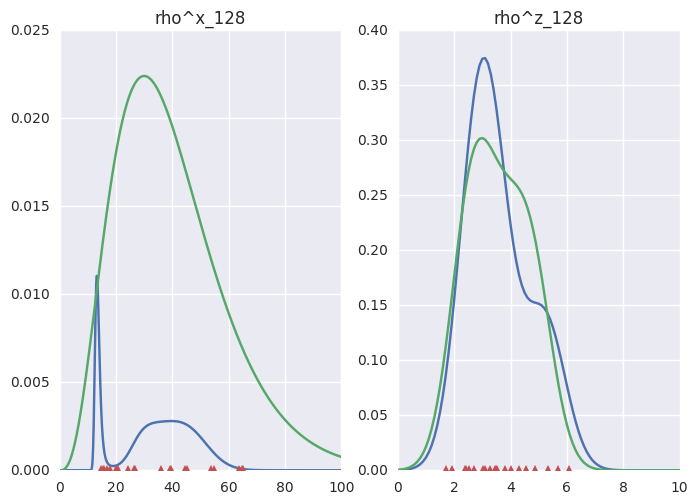

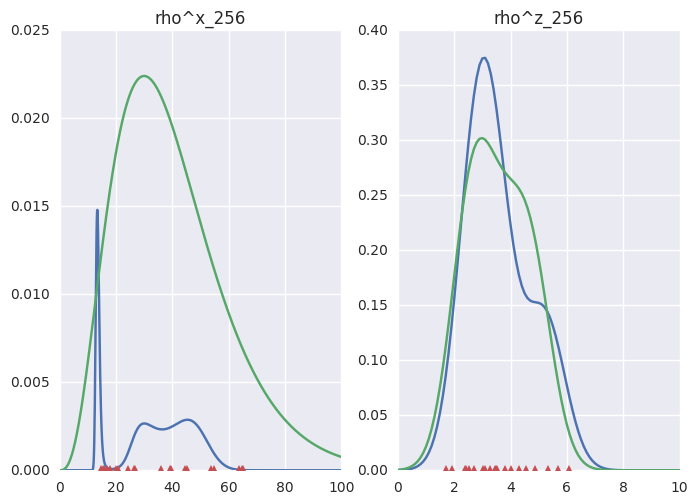

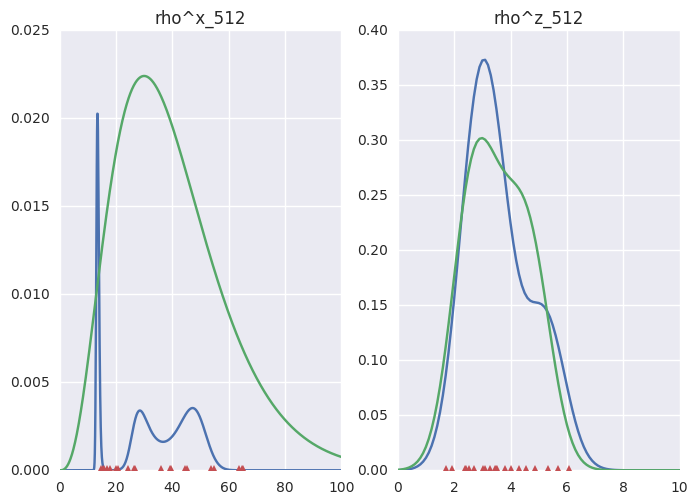

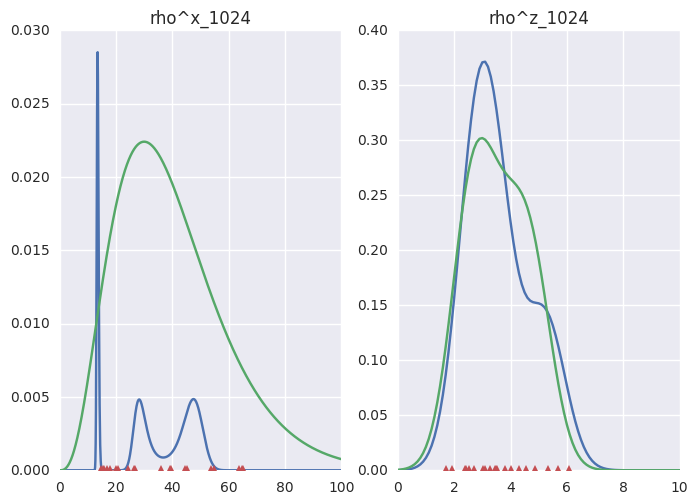

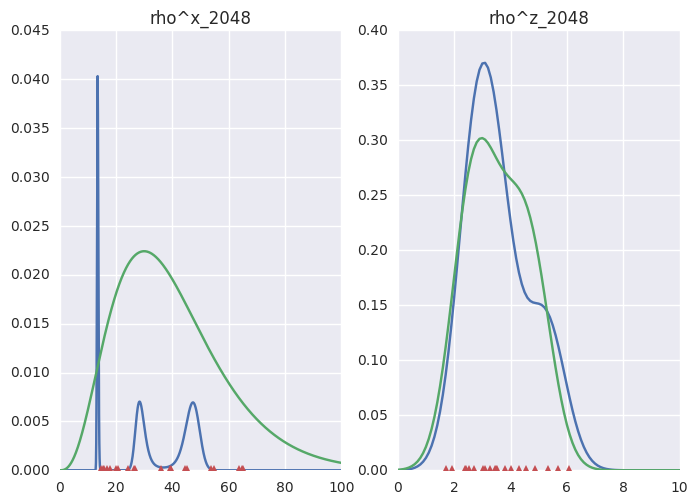

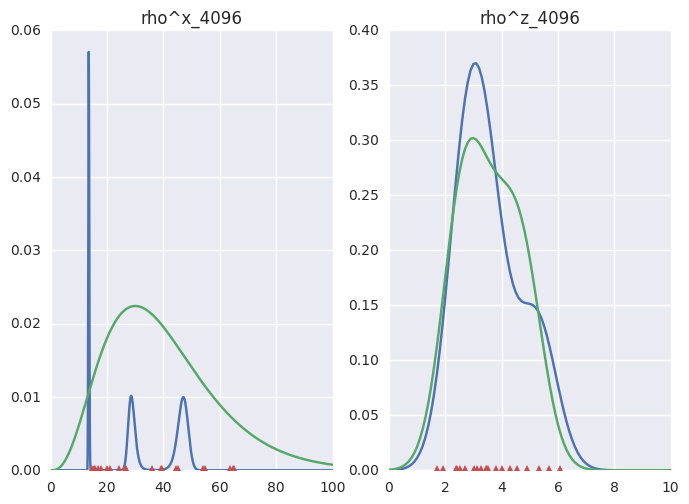

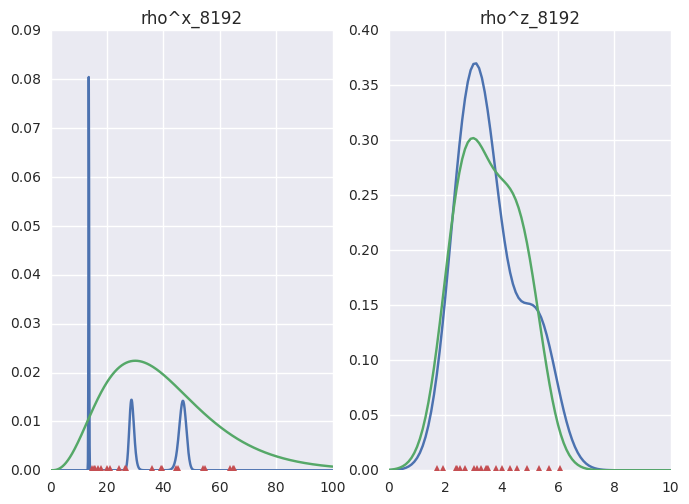

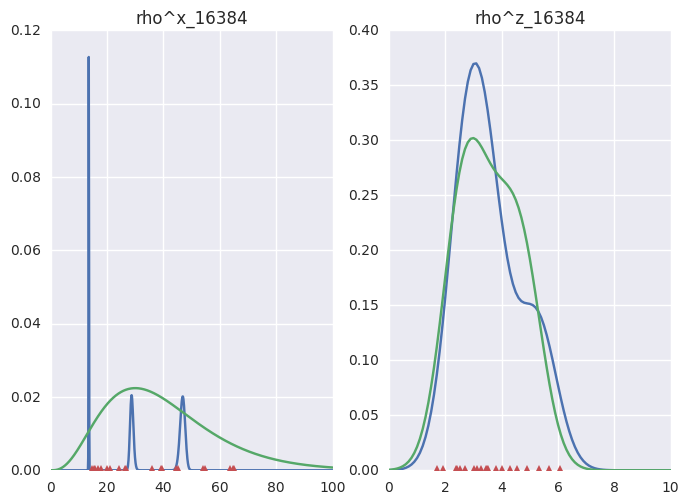

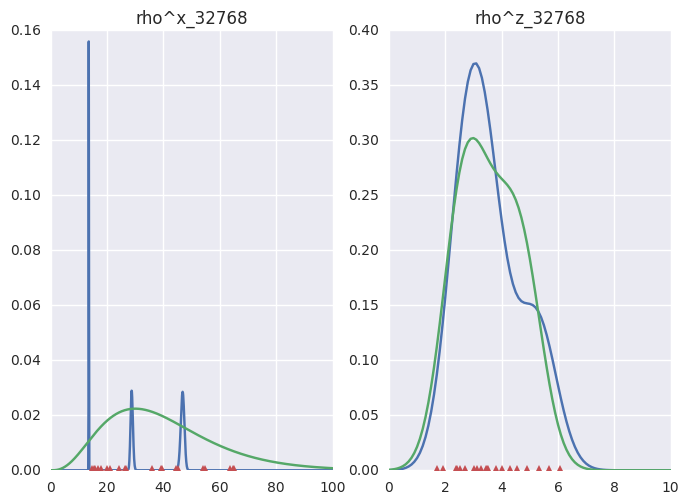

7.127722 seconds (377.02 k allocations: 17.281 MB, 0.25% gc time)


In [31]:
@time pi_n = store_iterates(GynC.reweight!, pi0_gridded(ztrue), range);

plothistory(pi_n, xtrue, ztrue)

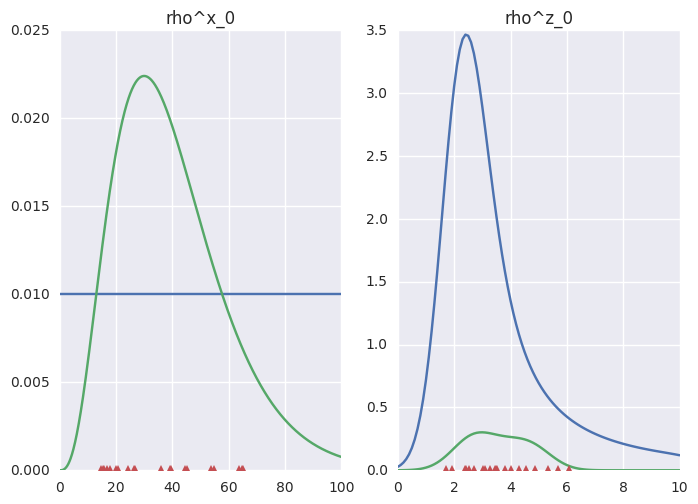

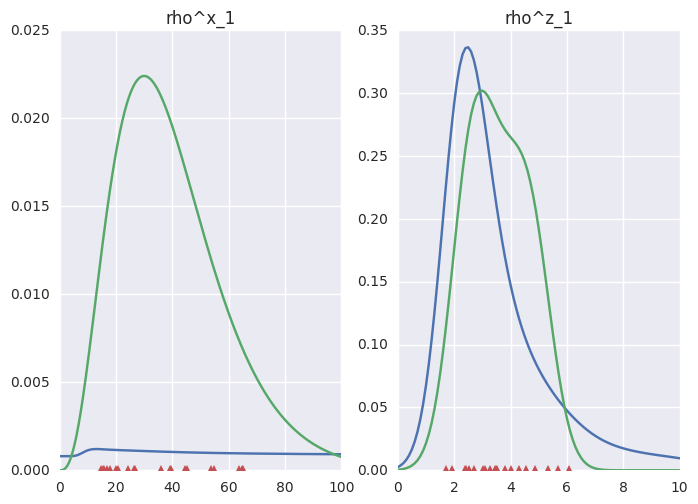

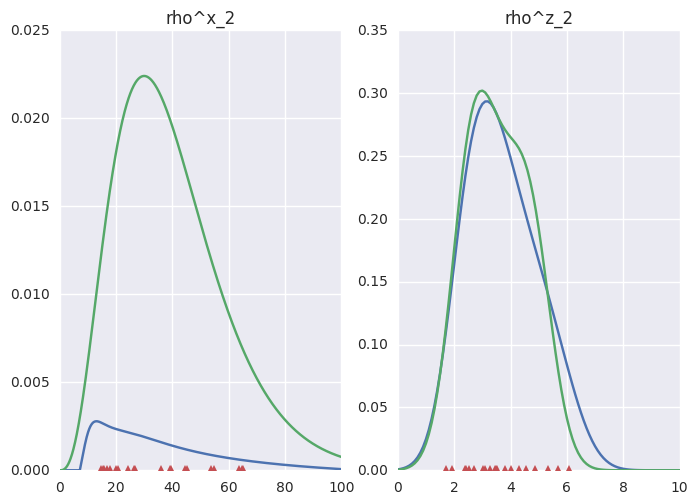

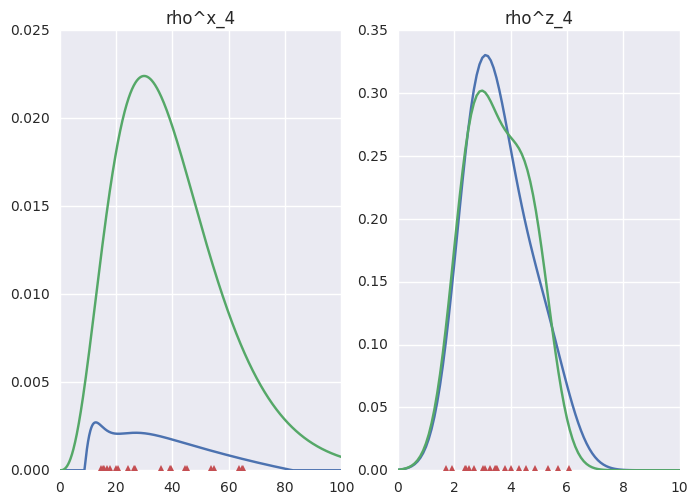

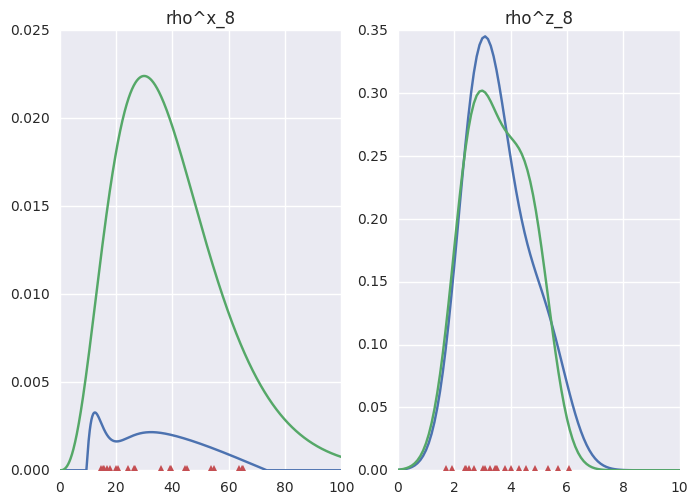

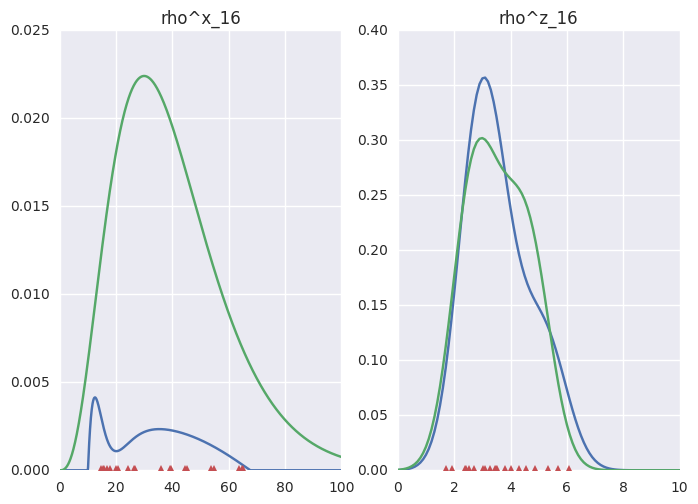

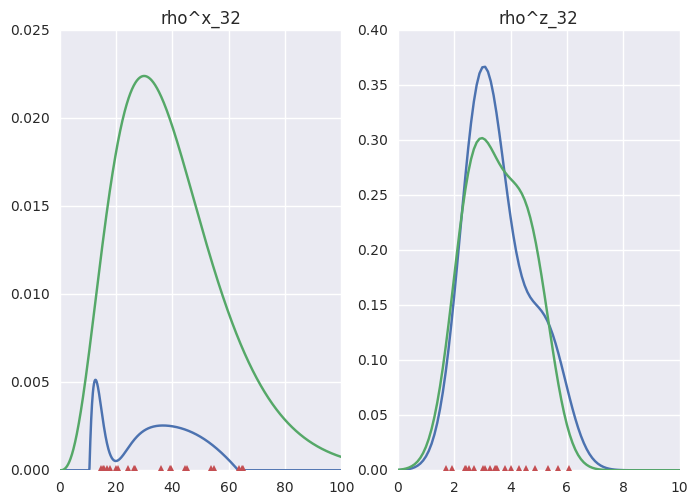

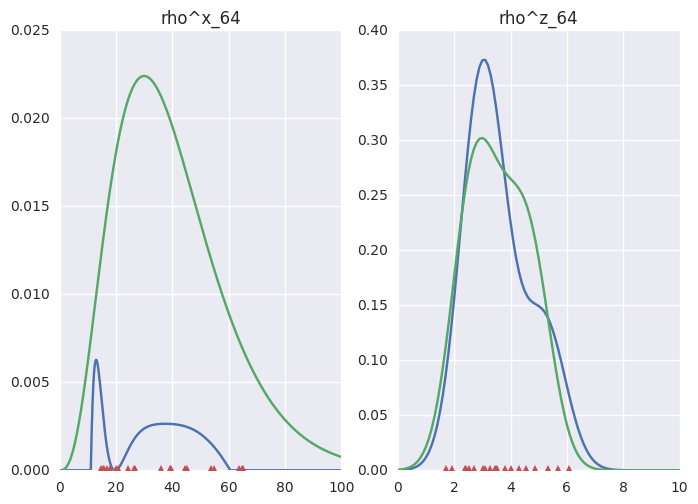

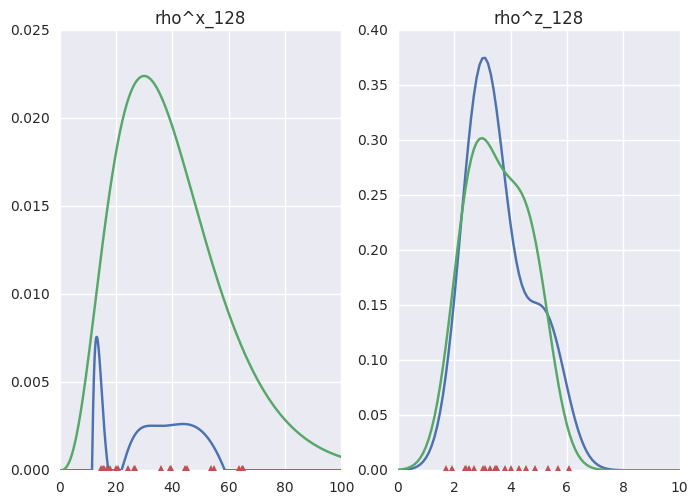

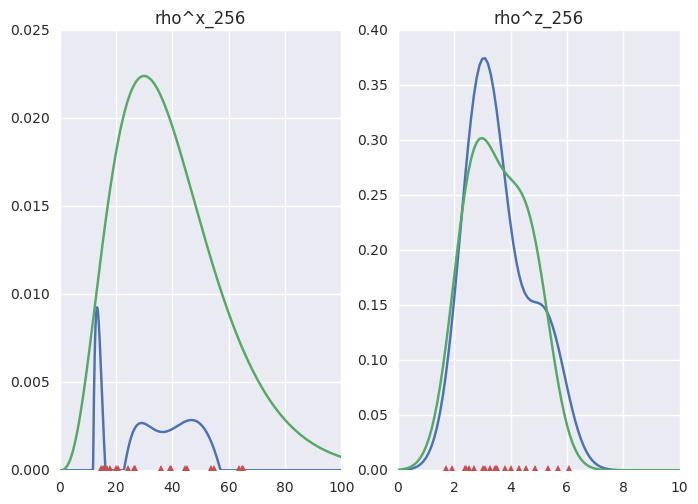

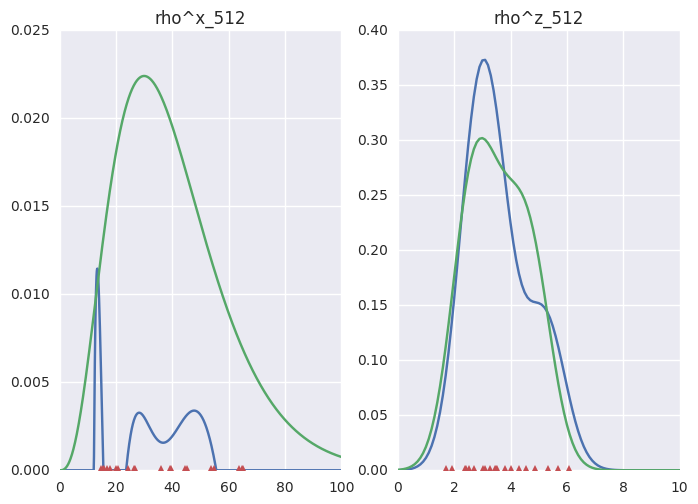

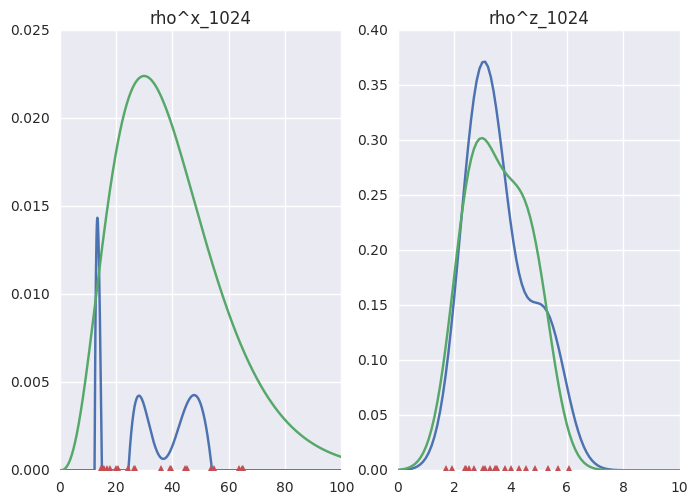

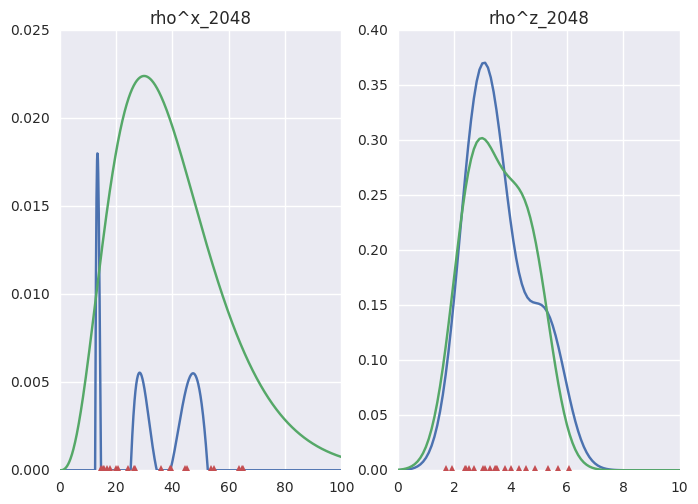

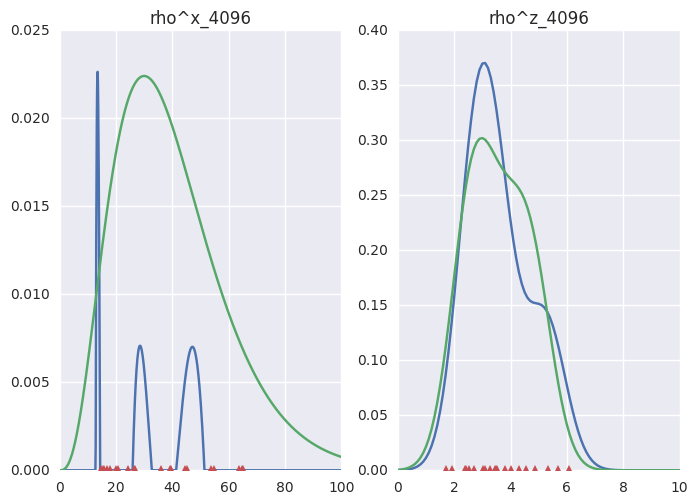

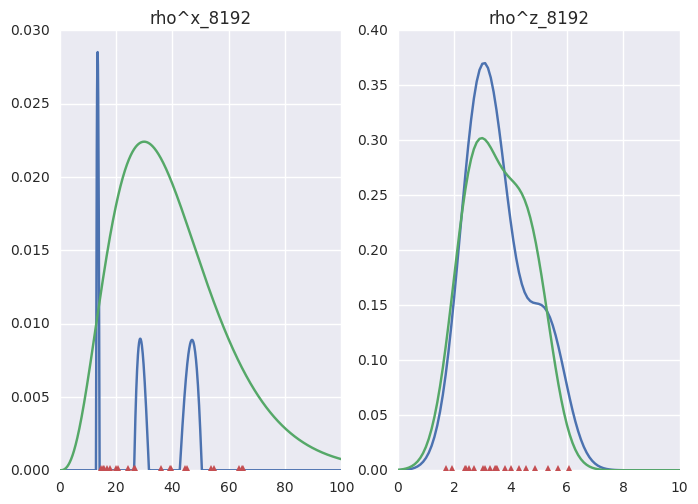

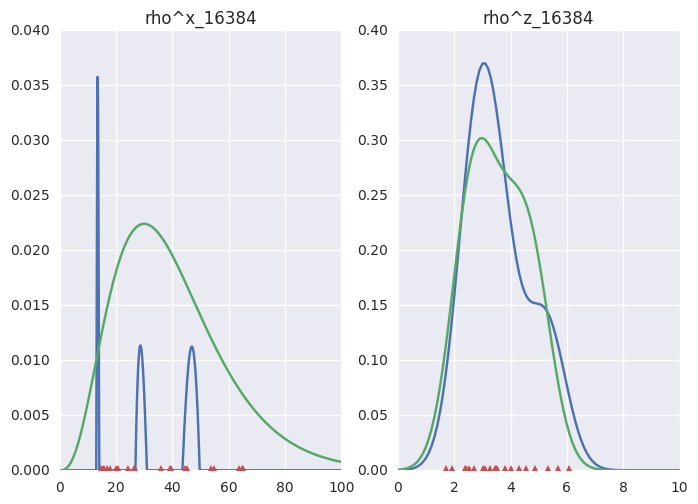

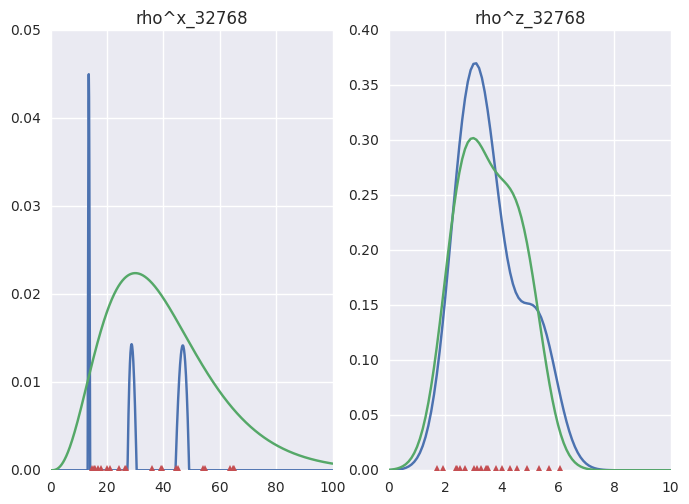

3.882577 seconds (704.73 k allocations: 1.014 GB, 6.18% gc time)


In [32]:
@time pi_n = store_iterates(c->GynC.gradient_simplex!(c, 0.0001), pi0_gridded(ztrue), range);

plothistory(pi_n, xtrue, ztrue)